# 20.440. Final Project:

##1. Install libraries (if needed)

In [32]:
# Installing the 'biomart' library, used for querying BioMart databases for biological data.
!pip install biomart

# Installing the 'fastcluster' library,  provides efficient algorithms for hierarchical, agglomerative clustering.
!pip install fastcluster

# Installing the 'gseapy' library, is a Python wrapper for the Gene Set Enrichment Analysis (GSEA) and other gene set analysis methods.
!pip install gseapy

# Installing the 'adjustText' library,  helps in automatically adjusting text position in matplotlib plots to minimize overlaps.
!pip install adjustText


##2. Import the libraries

In [33]:
import seaborn as sns  # Seaborn 0.12.0: Data visualization library based on matplotlib, provides a high-level interface for drawing statistical graphics.

import pandas as pd  # Pandas 1.4.3: Library providing high-performance, easy-to-use data structures, and data analysis tools.

import scipy  # SciPy 1.9.1: Library used for scientific and technical computing.

import numpy as np  # NumPy 1.24.1: Fundamental package for scientific computing with Python (arrays, matrices, and high-level math functions).

from matplotlib import pyplot as plt  # Matplotlib 3.6.2: Plotting library for creating static, interactive, and animated visualizations in Python.

import matplotlib.colors  # Provides a useful set of functions for handling color transformations and color map handling.

from matplotlib.lines import Line2D  # Used for creating line objects that can be added to plots.

import matplotlib.patches as mpatches  # Used for creating patch shapes like circles and rectangles to add to plots.

from scipy import stats  # Module in SciPy focused on statistical functions: distributions, statistical tests, kernel density estimates, etc.

import itertools  # Standard library module for efficient looping and creation of complex iterators.

from tabulate import tabulate  # Tabulate 0.9.0: Library to create tables and formatted output from lists and arrays.

from adjustText import adjust_text  # adjustText 0.9.1: A library for automatic adjustment of text positions in matplotlib plots to minimize overlaps.

from biomart import BiomartServer  # BioMart 0.10.0: Library to interact with BioMart data services, enabling complex queries of biological databases.

from io import StringIO  # Standard library module for in-memory file-like object operations. This can be used to read and write strings as files.


##3. Access Google Drive

In [35]:
# Importing necessary libraries from the google.colab package.
from google.colab import drive  # Handles mounting Google Drive in Colab.
from google.colab import files  # Facilitates file upload/download operations in Colab.

# Mount Google Drive to access files from it. This will prompt for authorization.
drive.mount('/content/google_drive')

# Import the os module to interact with the operating system.
import os

# Change the current working directory to the specified path in Google Drive.
os.chdir('/content/google_drive/MyDrive/')


Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


##4. Upload the required data frames

In [36]:
# List all files in the specified directory within Google Drive and store them in the variable.
# Change folder accordingly
directory_files = os.listdir('/content/google_drive/MyDrive/440 project E + V 4ever/Data')

# Iterate over the list of files and print each file name. This helps in verifying the files in the directory.
for file in directory_files:
    print(file)

# Read a tab-separated values (tsv) file into DataFrame. Specify the separator as a tab character.
original_df = pd.read_csv('440 project E + V 4ever/Data/All_data.txt', sep='\t')


All_data.txt
Old data
Patient baseline
Controls
Patient wk12
P0vsP12.csv
CvsP12.csv
CvsP0.csv
Play_data.txt


##5. Clean the dataset

In [37]:
# Use the dropna method to remove all rows from the DataFrame that contain any missing values (NA).
cleaned_df = original_df.dropna()

# Notes on original_df:

# Patients 5, 7, and 12 are missing because they didn't receive biopsies at week 12.
# This information is crucial as it explains the reason behind the missing data for these patients.
# Patients 5, 6, and 7 are non-responders; thus, original_df includes data from a non-responder (patient 6).

# Understanding the responder status is important for analysis as it may influence the results and interpretations.


In [38]:
# Drop the columns corresponding to non-responder patient 6 at both time points (w0 and w12)
# from the DataFrame to focus only on controls and responders.

df_responders = original_df.drop(columns=['P6_0', 'P6_12'])

# Notes on df_responders structure:
# Controls = columns 1-3 (n = 3): These columns contain data for the control group, which are typically healthy subjects or baseline measurements.
# Patients t0 = columns 4-11 (n = 8): This subset includes measurements from 8 patients at time 0.
# Patients t12 = columns 12-19 (n = 8): This subset contains measurements from the same 8 patients at time 12 weeks, allowing for comparison over time.


In [39]:
# Create DataFrame for controls with predefined columns.
controls = pd.DataFrame(columns=['C0', 'C1', 'C2'])

# Assign data to the controls DataFrame by extracting specific columns from df_responders.
controls['C0'] = df_responders.iloc[:, 1]  # Data from the second column of df_responders (0-indexed)
controls['C1'] = df_responders.iloc[:, 2]  # Data from the third column
controls['C2'] = df_responders.iloc[:, 3]  # Data from the fourth column

# Create DataFrame for patients at time 0 with predefined columns.
p0 = pd.DataFrame(columns=['P1', 'P2', 'P3', 'P4', 'P8', 'P9', 'P10', 'P11'])

# Assign data to the p0 DataFrame by extracting columns for each patient at time 0.
p0['P1'] = df_responders.iloc[:, 4]
p0['P2'] = df_responders.iloc[:, 5]
p0['P3'] = df_responders.iloc[:, 6]
p0['P4'] = df_responders.iloc[:, 7]
p0['P8'] = df_responders.iloc[:, 8]
p0['P9'] = df_responders.iloc[:, 9]
p0['P10'] = df_responders.iloc[:, 10]
p0['P11'] = df_responders.iloc[:, 11]

# Create DataFrame for patients at time 12 with the same structure as for time 0.
p12 = pd.DataFrame(columns=['P1', 'P2', 'P3', 'P4', 'P8', 'P9', 'P10', 'P11'])

# Assign data to the p12 DataFrame by extracting columns for each patient at time 12.
p12['P1'] = df_responders.iloc[:, 12]
p12['P2'] = df_responders.iloc[:, 13]
p12['P3'] = df_responders.iloc[:, 14]
p12['P4'] = df_responders.iloc[:, 15]
p12['P8'] = df_responders.iloc[:, 16]
p12['P9'] = df_responders.iloc[:, 17]
p12['P10'] = df_responders.iloc[:, 18]
p12['P11'] = df_responders.iloc[:, 19]


##6. Perform Shapiro Wilk (normality)

In [40]:
# Initialize an empty list to store results of normality tests.
normal_results = []

# Iterate over the indices of df_responders DataFrame to perform Shapiro-Wilk test for normality on each group.
for a in range(len(df_responders)):

    # Perform Shapiro-Wilk test for normality on the control group.
    s_test_c, s_p_c = scipy.stats.shapiro(controls.iloc[a, :])

    # Perform Shapiro-Wilk test for normality on the patient group at time 0.
    s_test_p0, s_p_p0 = scipy.stats.shapiro(p0.iloc[a, :])

    # Perform Shapiro-Wilk test for normality on the patient group at time 12.
    s_test_p12, s_p_p12 = scipy.stats.shapiro(p12.iloc[a, :])

    # Append the results including the reference ID and p-values for each group to the results list.
    normal_results.append({
        'ID_REF': df_responders.iloc[a, 0],  # The reference ID from the first column of df_responders
        'C_pvalue': s_p_c,  # P-value for the control group
        'P0_pvalue': s_p_p0,  # P-value for the patient group at time 0
        'P12_pvalue': s_p_p12  # P-value for the patient group at time 12
    })

# Convert the list of dictionaries into a DataFrame for easier viewing and analysis.
shapiro_results = pd.DataFrame(normal_results)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1887: RuntimeWarning: invalid value encountered in arccos
  pw = 1 - 6/np.pi*np.arccos(np.sqrt(w))


##7. Perform Student's T Test

In [48]:
# Initialize an empty list to store results of the Student's T-tests.
t_results = []

# Iterate over the indices of df_responders DataFrame to perform T-tests between different groups.
for a in range(len(df_responders)):

  # Perform T-test between controls and patients at time 0.
  c_p0_test, c_p0_p = scipy.stats.ttest_ind(controls.iloc[a,:],p0.iloc[a,:])

  # Calculate log2 fold change between means of patients at time 0 and controls.
  log2fc_1 = np.mean(p0.iloc[a,:])-np.mean(controls.iloc[a,:])

  # Perform T-test between controls and patients at time 12.
  c_p12_test, c_p12_p = scipy.stats.ttest_ind(controls.iloc[a,:],p12.iloc[a,:])

  # Calculate log2 fold change between means of patients at time 12 and controls.
  log2fc_2 = np.mean(p12.iloc[a,:])-np.mean(controls.iloc[a,:])

  # Perform T-test between patients at time 0 and time 12.
  p0_p12_test, p0_p12_p = scipy.stats.ttest_ind(p0.iloc[a,:],p12.iloc[a,:])

  # Calculate log2 fold change between means of patients at time 12 and time 0.
  log2fc_3 = np.mean(p12.iloc[a,:])-np.mean(p0.iloc[a,:])

  # Append the test results including the reference ID and p-values to the results list.
  t_results.append({
    'ID_REF': df_responders.iloc[a, 0], # The reference ID from the first column of df_responders
    'C vs P0 pvalue': c_p0_p,
    'C vs P0 log2fc': log2fc_1,
    'C vs P12 pvalue': c_p12_p,
    'C vs P12 log2fc': log2fc_2,
    'P0 vs P12 pvalue': p0_p12_p,
    'P0 vs P12 log2fc': log2fc_3
  })

# Convert the list of dictionaries into a DataFrame for easier viewing and analysis.
t_test_results = pd.DataFrame(t_results)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# Filter and create tables for significant genes based on statistical and fold change criteria for each comparison.
# Criteria: p-value < 0.05 and absolute log2 fold change > 1.

# Filter the t_test_results DataFrame for significant results between controls and patients at time 0 (C vs P0).
CvsP0 = t_test_results.loc[(t_test_results['C vs P0 pvalue'] < 0.05) & ((t_test_results['C vs P0 log2fc'] > 1) | (t_test_results['C vs P0 log2fc'] < -1))]

# Filter the t_test_results DataFrame for significant results between controls and patients at time 12 (C vs P12).
CvsP12 = t_test_results.loc[(t_test_results['C vs P12 pvalue'] < 0.05) & ((t_test_results['C vs P12 log2fc'] > 1) | (t_test_results['C vs P12 log2fc'] < -1))]

# Filter the t_test_results DataFrame for significant results between patients at time 0 and time 12 (P0 vs P12).
P0vsP12 = t_test_results.loc[(t_test_results['P0 vs P12 pvalue'] < 0.05) & ((t_test_results['P0 vs P12 log2fc'] > 1) | (t_test_results['P0 vs P12 log2fc'] < -1))]

##8. Enrichment analysis

In [54]:
# Retrieve unique Affymetrix IDs from the t_test_results DataFrame to ensure no duplicates.
unique_affy_ids = t_test_results['ID_REF'].unique()

# Connect to the BioMart server
server = BiomartServer("http://www.ensembl.org/biomart")

# Select the human genes dataset from the server.
dataset = server.datasets['hsapiens_gene_ensembl']

# Configure the query for the dataset.
# Filters are used to specify which genes to retrieve, and attributes define the data columns to be returned.
# Affymetrix array used: 'affy_hg_u133_plus_2'
response = dataset.search({
    'filters': {
        'with_affy_hg_u133_plus_2': True  # Only retrieve genes that are on the Affy HG U133 Plus 2.0 array
        },
    'attributes': [
        'affy_hg_u133_plus_2',  # Affymetrix ID
        'ensembl_gene_id',      # Ensembl Gene ID
        'external_gene_name'    # Gene name
    ]
})

# Convert the response text to a DataFrame for easier manipulation.
# The response is parsed as tab-separated values (TSV).
hsapiens_ensembl = pd.read_csv(StringIO(response.text), sep='\t', names=['ID_REF', 'Ensembl_ID', 'Gene_Name'])

# Filter the results to include only those entries that match the unique Affymetrix IDs we have.
matched_data_filtered = hsapiens_ensembl[hsapiens_ensembl['ID_REF'].isin(unique_affy_ids)]

In [55]:
# Merge the t_test_results DataFrame with the matched_data_filtered DataFrame.
# The merge is performed on the 'ID_REF' column, which is common to both DataFrames.
# The 'left' join ensures that all entries from t_test_results are included in the merged result,
# and gene annotations are added where matches are found.
t_test_results_with_genes = t_test_results.merge(matched_data_filtered, on='ID_REF', how='left')

# Remove rows that contain missing values.
# This step cleans the dataset by dropping rows where no matching gene information was found,
# ensuring that only fully annotated results are retained for further analysis.
t_test_results_with_genes = t_test_results_with_genes.dropna()


In [56]:
# Filter significant results for each comparison and save to CSV files in a specified Google Drive directory.

# Filter for significant changes between controls and patients at time 0 (C vs P0).
CvsP0 = t_test_results_with_genes.loc[(t_test_results_with_genes['C vs P0 pvalue'] < 0.05) & ((t_test_results_with_genes['C vs P0 log2fc'] > 1) | (t_test_results_with_genes['C vs P0 log2fc'] < -1))]

# Save the filtered results to a CSV file, dropping irrelevant columns for this comparison.
CvsP0.drop(columns = ['C vs P12 pvalue','C vs P12 log2fc', 'P0 vs P12 pvalue', 'P0 vs P12 log2fc']).to_csv('/content/google_drive/MyDrive/440 project E + V 4ever/Results/Dataframes/CvsP0.csv')

# Filter for significant changes between controls and patients at time 12 (C vs P12).
CvsP12 = t_test_results_with_genes.loc[(t_test_results_with_genes['C vs P12 pvalue'] < 0.05) & ((t_test_results_with_genes['C vs P12 log2fc'] > 1) | (t_test_results_with_genes['C vs P12 log2fc'] < -1))]

# Save the filtered results to a CSV file, dropping irrelevant columns for this comparison.
CvsP12.drop(columns = ['C vs P0 pvalue','C vs P0 log2fc', 'P0 vs P12 pvalue', 'P0 vs P12 log2fc']).to_csv('/content/google_drive/MyDrive/440 project E + V 4ever/Results/Dataframes/CvsP12.csv')

# Filter for significant changes between patients at time 0 and time 12 (P0 vs P12).
P0vsP12 = t_test_results_with_genes.loc[(t_test_results_with_genes['P0 vs P12 pvalue'] < 0.05) & ((t_test_results_with_genes['P0 vs P12 log2fc'] > 1) | (t_test_results_with_genes['P0 vs P12 log2fc'] < -1))]

# Save the filtered results to a CSV file, dropping irrelevant columns for this comparison.
P0vsP12.drop(columns = ['C vs P12 pvalue','C vs P12 log2fc', 'C vs P0 pvalue', 'C vs P0 log2fc']).to_csv('/content/google_drive/MyDrive/440 project E + V 4ever/Results/Dataframes/P0vsP12.csv')

##9. Volcano plot

Top Genes for C vs P0
+-------+-----------+---------------------+------------------------+
|       | Gene_Name |   C vs P0 log2fc    |     C vs P0 pvalue     |
+-------+-----------+---------------------+------------------------+
| 15908 |   CXCL9   |  4.786954166666666  | 0.0007101807614117897  |
| 56041 |  SLC44A5  |  4.465845833333335  |  0.04355248594719768   |
| 66044 |   CCL18   | 3.7871708333333327  |  0.001998484165211828  |
| 66045 |   CCL18   | 3.7871708333333327  |  0.001998484165211828  |
| 66046 |   CCL18   | 3.7871708333333327  |  0.001998484165211828  |
| 23751 |   CCL18   |      3.6990125      | 0.0014712732969051887  |
| 23752 |   CCL18   |      3.6990125      | 0.0014712732969051887  |
| 23753 |   CCL18   |      3.6990125      | 0.0014712732969051887  |
| 18159 |   CD8A    | 3.2699041666666666  | 2.3973064025415523e-05 |
| 30251 |   IGLJ2   | 3.0759958333333337  |  0.04957592884865801   |
| 9048  | KRTAP8-1  | -6.713304166666667  |  0.01812994207260981   |
| 55031 | KR

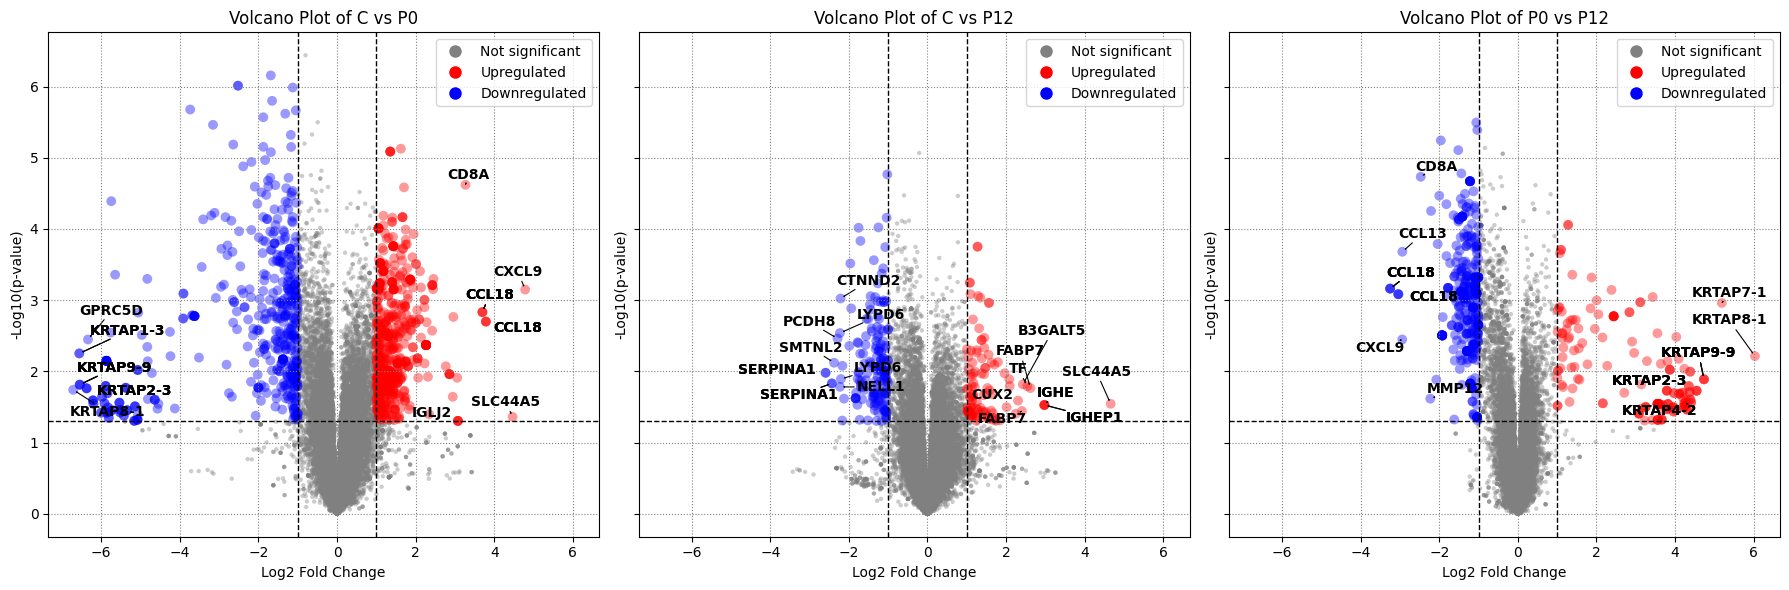

In [69]:
 # Calculate the negative log10 of the p-values to transform them for better visualization in volcano plots.
t_test_results_with_genes['neg_log10_C vs P0 pvalue'] = -np.log10(t_test_results_with_genes['C vs P0 pvalue'])
t_test_results_with_genes['neg_log10_C vs P12 pvalue'] = -np.log10(t_test_results_with_genes['C vs P12 pvalue'])
t_test_results_with_genes['neg_log10_P0 vs P12 pvalue'] = -np.log10(t_test_results_with_genes['P0 vs P12 pvalue'])

# Define thresholds for significance in terms of p-value and log fold change.
logfc_threshold = 1.0  # Threshold for log2 fold change to consider a gene significantly up/down-regulated.
pvalue_threshold = 0.05  # P-value threshold for statistical significance.

# Initialize a dictionary to store filtered data of significant upregulated and downregulated genes.
significant_genes = {
    'C vs P0': {'upregulated': None, 'downregulated': None},
    'C vs P12': {'upregulated': None, 'downregulated': None},
    'P0 vs P12': {'upregulated': None, 'downregulated': None}
}

# Create a figure with three subplots, one for each comparison, sharing the same x and y axes for consistency.
fig, axes = plt.subplots(1, 3, figsize=(18, 6),sharex=True, sharey=True)
titles = ['C vs P0', 'C vs P12', 'P0 vs P12']

# Define custom legend symbols for different categories of points in the plot.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not significant',
           markerfacecolor='grey', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Upregulated',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Downregulated',
           markerfacecolor='blue', markersize=10),
]

# Loop over each comparison to plot the data.
for i, (logfc_col, pval_col, title) in enumerate(zip(
        ['C vs P0 log2fc', 'C vs P12 log2fc', 'P0 vs P12 log2fc'],
        ['neg_log10_C vs P0 pvalue', 'neg_log10_C vs P12 pvalue', 'neg_log10_P0 vs P12 pvalue'],
        titles)):

    # Filter data into significant upregulated, downregulated, and non-significant groups based on thresholds.
    significant_up = t_test_results_with_genes[
        (t_test_results_with_genes[logfc_col] >= logfc_threshold) &
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] <= pvalue_threshold)
    ]

    significant_down = t_test_results_with_genes[
        (t_test_results_with_genes[logfc_col] <= -logfc_threshold) &
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] <= pvalue_threshold)
    ]

    non_significant = t_test_results_with_genes[
        (abs(t_test_results_with_genes[logfc_col]) < logfc_threshold) |
        (t_test_results_with_genes[pval_col.replace('neg_log10_', '')] > pvalue_threshold)
    ]

    # Store significant genes in dictionary for access later if needed.
    significant_genes[title]['upregulated'] = significant_up
    significant_genes[title]['downregulated'] = significant_down

    # Plot data points: non-significant in grey, significant upregulated in red, and downregulated in blue.
    axes[i].scatter(non_significant[logfc_col], non_significant[pval_col], s=10, color='grey', alpha=0.4, edgecolors='none')
    axes[i].scatter(significant_up[logfc_col], significant_up[pval_col], s=50, color='red', alpha=0.4, edgecolors='none')
    axes[i].scatter(significant_down[logfc_col], significant_down[pval_col], s=50, color='blue', alpha=0.4, edgecolors='none')

    # Annotate top significant genes directly on the plot to highlight key findings.
    top_genes_up = significant_up.nlargest(10, logfc_col)
    top_genes_down = significant_down.nsmallest(10, logfc_col, keep='all')

    # Combine top upregulated and downregulated genes
    top_genes = pd.concat([top_genes_up, top_genes_down])

    # Print the table with the top 10
    print(f"Top Genes for {title}")
    print(tabulate(top_genes[['Gene_Name', 'C vs P0 log2fc', 'C vs P0 pvalue']], headers='keys', tablefmt='pretty'))
    print("\n")

    # Prepare annotations
    texts = [axes[i].text(row[logfc_col], row[pval_col], row['Gene_Name'], ha='center', fontweight='bold') for _, row in top_genes.iterrows()]

    # Adjust text to repel labels using adjust_text
    adjust_text(texts, ax=axes[i], arrowprops=dict(arrowstyle="->", color='black', lw=0.8))

    # Add styling and labels to each subplot.
    axes[i].legend(handles=legend_elements, loc='upper right')
    axes[i].set_title(f'Volcano Plot of {title}')
    axes[i].set_xlabel('Log2 Fold Change')
    axes[i].set_ylabel('-Log10(p-value)')
    axes[i].axhline(y=-np.log10(pvalue_threshold), color='black', linestyle='--', linewidth=1)
    axes[i].axvline(x=logfc_threshold, color='black', linestyle='--', linewidth=1)
    axes[i].axvline(x=-logfc_threshold, color='black', linestyle='--', linewidth=1)
    axes[i].grid(True, linestyle=':', color='grey')

    # Save each plot as a JPEG file.
    plt.savefig(f'/content/google_drive/MyDrive/440 project E + V 4ever/Results/Figures/Volcano Plot of {title}.jpeg')

# Ensure the plots are laid out without overlap and display the figure.
plt.tight_layout()
plt.show()


In [58]:
# Dictionary to store the cleaned DataFrames
cleaned_data_frames = {}

# Iterate through the significant_genes dictionary to process each group's data.
for group, data in significant_genes.items():
    # Create a copy of upregulated genes, add a new column to indicate the regulation status.
    upregulated_df = data['upregulated'].copy()
    upregulated_df['Regulation'] = 'upregulated'

    # Repeat the process for downregulated genes.
    downregulated_df = data['downregulated'].copy()
    downregulated_df['Regulation'] = 'downregulated'

    # Combine the upregulated and downregulated DataFrames into one.
    combined_df = pd.concat([upregulated_df, downregulated_df])

    # Merge the combined DataFrame with df_responders to include more context or additional data.
    significant_all_data = combined_df[['ID_REF', 'Ensembl_ID', 'Gene_Name', 'Regulation']].merge(df_responders, on='ID_REF', how='left')

    # Clean the resulting DataFrame by dropping any rows that contain NaN values, ensuring data integrity.
    cleaned_df = significant_all_data.dropna()

    # Store the cleaned DataFrame in a dictionary, categorized by the group.
    cleaned_data_frames[group] = cleaned_df

# Now, cleaned_data_frames contains cleaned DataFrames for each group
# Accessing the cleaned DataFrames, for example:
C_vs_P0_cleaned = cleaned_data_frames['C vs P0']
C_vs_P12_cleaned = cleaned_data_frames['C vs P12']
P0_vs_P12_cleaned = cleaned_data_frames['P0 vs P12']

## 10. ALADIN: KRT, CTL, IFN and ANT

In [59]:
# Load the dataset containing Affymetrix IDs
alldata_df = pd.read_csv('440 project E + V 4ever/Data/Play_data.txt', sep = '\t')

# Extract unique Affymetrix IDs from the dataset to ensure there are no duplicates
unique_affy_ids_all = alldata_df['ID_REF'].unique()  # Ensure unique IDs

# Connect to the BioMart server for accessing the biological database
server = BiomartServer("http://www.ensembl.org/biomart")

# Select the dataset for human genes
dataset = server.datasets['hsapiens_gene_ensembl']

# Configure and execute the search to retrieve data related to the Affymetrix HG U133 Plus 2.0 array
# Affymetrix array used: 'affy_hg_u133_plus_2'
response = dataset.search({
    'filters': {
        'with_affy_hg_u133_plus_2': True  # Get all genes with Affy HG U133 Plus 2.0
        },
    'attributes': [
        'affy_hg_u133_plus_2',  # Affymetrix ID
        'ensembl_gene_id',     # Ensembl Gene ID
        'external_gene_name'   # Gene name
    ]
})

# Convert the response into a DataFrame
hsapiens_ensembl = pd.read_csv(StringIO(response.text), sep='\t', names=['ID_REF', 'Ensembl_ID', 'Gene_Name'])

# Merge the data to match the unique Affymetrix IDs from the initial dataset with the BioMart data
matched_data_filtered_all = hsapiens_ensembl[hsapiens_ensembl['ID_REF'].isin(unique_affy_ids_all)]

In [ ]:
# Merge the gene information from BioMart with the Affymetrix microarray data.
aladin_data = matched_data_filtered_all.merge(alldata_df, on='ID_REF', how='left')

In [60]:
# Define gene lists for different biological or functional groups to facilitate focused analyses:
gene_list_CTL = ['CD8A','GZMB','ICOS','PRF1']  # CTL (Cytotoxic T Lymphocytes) genes involved in immune response and cell-mediated cytotoxicity.
gene_list_IFN = ['CXCL10','CXCL11','CXCL9','MX1','STAT1']  # IFN (Interferon) response genes, typically upregulated in viral infections and immune responses.
gene_list_KRT = ['DSG4','HOXC13','KRT31','KRT33B','KRT82','PKP']  # KRT (Keratin) genes, associated with the structural integrity of epithelial cells.
gene_list_ANT = ['IGLJ2','IGLC2','IGLJ3','IGLC3','IGHEP1','IGHE']  # ANT (Antibodies) genes, key components in the humoral immune response.

# Define column groups for data analysis, categorizing samples by their clinical or experimental grouping:
control_col = ['C1','C2','C3']  # Columns representing control group samples, typically healthy subjects or baseline measurements.
patient_0d =['P1_0','P2_0','P3_0','P4_0','P8_0','P9_0','P10_0','P11_0']  # Columns representing patient samples taken at initial time point (Day 0).
patient_12d = ['P1_12','P2_12','P3_12','P4_12','P8_12','P9_12','P10_12','P11_12']  # Columns for patient samples collected 12 days after the initial point, used for longitudinal studies.
patient_non_responders = ['P5_0','P6_0','P7_0','P6_12']  # Columns for patient samples identified as non-responders to the treatment or condition at initial and follow-up times.


In [61]:
def standardize_patient_data(df, gene_list):

    # Filter the DataFrame for genes included in the specified gene list
    filtered_df = df[df['Gene_Name'].isin(gene_list)]

    # Calculate the mean and standard deviation of expression values across the control columns
    control_mean = filtered_df[control_col].mean(axis=1)
    control_std = filtered_df[control_col].std(axis=1)

    # Create a new DataFrame to store standardized scores, initializing it with gene names
    standardized_scores = pd.DataFrame(filtered_df['Gene_Name'], index=filtered_df.index)

    # Iterate through columns starting from the fourth column of the DataFrame
    for col in aladin_data.columns[3:].tolist():

        # Initialize a list to hold the standardized values for each patient in the current column
        patient_standardized_values = []

        # Loop over each row in the filtered DataFrame by index
        for idx in filtered_df.index:

            # Extract the expression value for the current gene and patient
            patient_value = filtered_df.at[idx, col]

            # Calculate the standardized expression value using the control mean and standard deviation
            standardized_value = (patient_value - control_mean[idx]) / control_std[idx]

            # Append the standardized value to the list
            patient_standardized_values.append(standardized_value)

        # Append the list of standardized values as a new column to the standardized_scores DataFrame
        standardized_scores[col] = patient_standardized_values

    return standardized_scores, filtered_df

# Apply the function to each gene list and DataFrame

standardized_scores_CTL, aladin_data_CTL   = standardize_patient_data(aladin_data, gene_list_CTL)
standardized_scores_IFN, aladin_data_IFN  = standardize_patient_data(aladin_data, gene_list_IFN)
standardized_scores_KRT, aladin_data_KRT  = standardize_patient_data(aladin_data, gene_list_KRT)
standardized_scores_ANT, aladin_data_ANT  = standardize_patient_data(aladin_data, gene_list_ANT)

##11. Heatmap for ALADIN

In [62]:
# Create a list to store multiple DataFrames, each associated with different gene groups.
# These DataFrames have been previously created and contain standardized or filtered data
# for specific gene lists: CTL, IFN, KRT, and ANT.
data_frames = [aladin_data_CTL, aladin_data_IFN, aladin_data_KRT, aladin_data_ANT]

In [63]:
# Define the group names associated with different gene groups.
group_names = ['CTL', 'IFN', 'KRT', 'ANT']

# Initialize an empty list to store the processed DataFrames
aladin_processed_dfs = []

# Loop through each DataFrame and its corresponding group name
for df, label in zip(data_frames, group_names):

    # Set 'Gene_Name' as the index of the DataFrame to facilitate operations on gene data
    aladin_indexed_df = df.set_index(['Gene_Name'])

    # Calculate the mean of each gene's expression across all samples (ignoring non-numeric columns)
    # .iloc[:,2:-1] is used to exclude non-numeric columns
    aladin_mean_df = aladin_indexed_df.iloc[:,2:-1].groupby(aladin_indexed_df.index).mean()

    # Add a new column 'Group' to the DataFrame with the label identifying the gene group
    aladin_mean_df['Group'] = label

    # Append the processed DataFrame to the list
    aladin_processed_dfs.append(aladin_mean_df)

# Concatenate all the processed DataFrames into a single DataFrame
aladin_combined_df = pd.concat(aladin_processed_dfs, ignore_index=False)

<Figure size 1000x800 with 0 Axes>

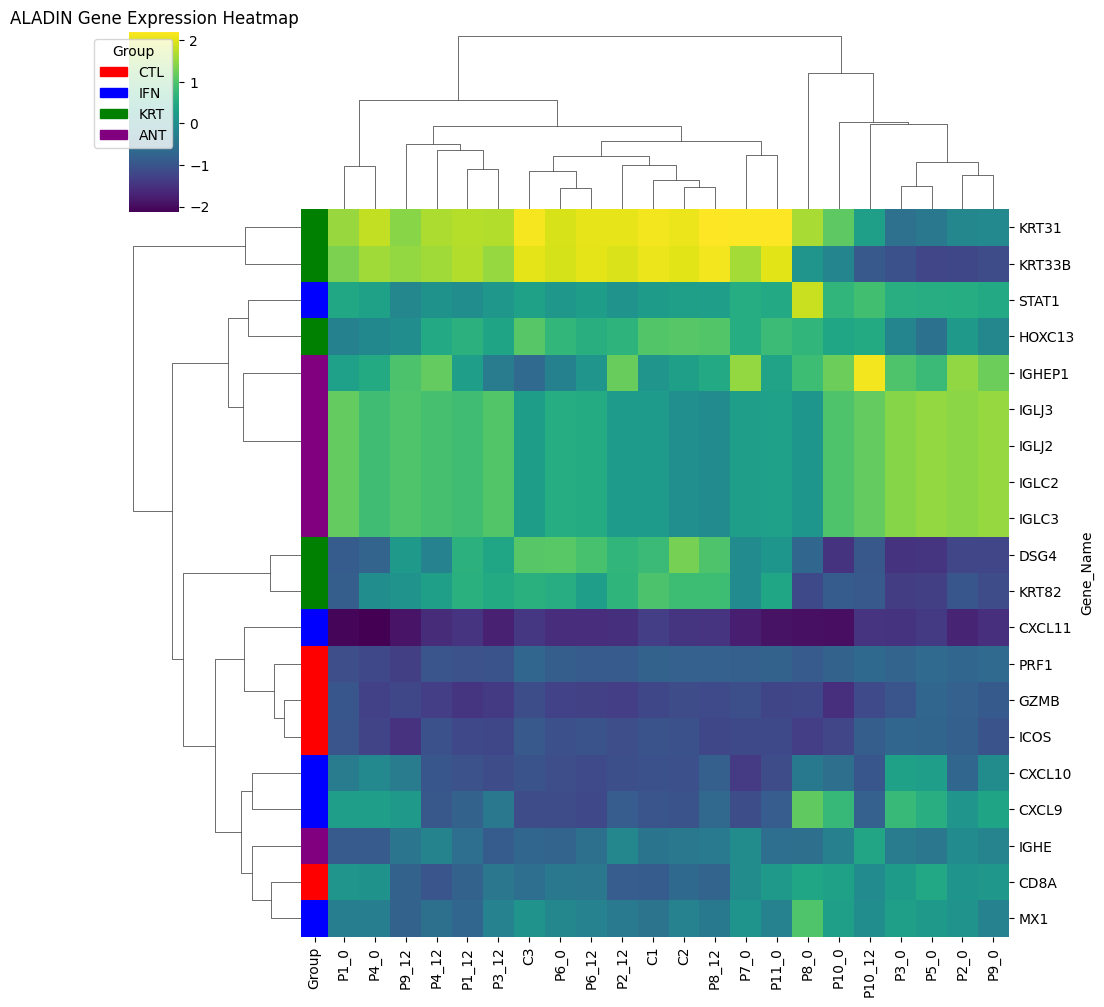

In [64]:
# Select only the patient values from the DataFrame, assuming these are in all but the last column.
aladin_combined_values_df = aladin_combined_df.iloc[:,0:-1]

# Standardize the DataFrame by calculating z-scores for each value.
# This centers the data around the mean with a unit standard deviation.
z_score_standardized = (aladin_combined_values_df - aladin_combined_values_df.mean()) / aladin_combined_values_df.std(ddof=0)

# Append the 'Group' column back to the standardized DataFrame.
z_score_standardized['Group'] = aladin_combined_df['Group']

# Set up the figure for plotting
plt.figure(figsize=(10, 8))

# Save the group information for use as row colors in the clustermap.
ordered_group_colors = aladin_combined_df['Group'].map({'CTL': 'red', 'IFN': 'blue', 'KRT': 'green', 'ANT': 'purple'})

# Generate a clustermap with hierarchical clustering using 'average' linkage and 'viridis' colormap.
# Exclude the 'Group' column for plotting, include row and column labels, and use the row colors.
g = sns.clustermap(z_score_standardized.iloc[:, :-1],
                   method='average', cmap='viridis',
                   xticklabels=True, yticklabels=True,
                   row_colors=ordered_group_colors.to_frame())

# Define and add a legend to the clustermap to identify groups by color.
group_colors = {'CTL': 'red', 'IFN': 'blue', 'KRT': 'green', 'ANT': 'purple'}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=legend_handles, title='Group', bbox_to_anchor=(1, 1), loc='upper right')

# Set the title for the clustermap.
plt.title('ALADIN Gene Expression Heatmap')

# Save the clustermap to a file in Google Drive.
plt.savefig(f'/content/google_drive/MyDrive/440 project E + V 4ever/Results/Figures/ALADIN_Gene_Expression_Heatmap_Z-score.jpeg')
plt.show()

##12. Boxplot for ALADIN

In [65]:
# Define the groups and the respective columns for easier data handling
groups_and_columns = {
    'Control': control_col,
    '0d': patient_0d,
    '12d': patient_12d,
    'Non-Responders Od': patient_non_responders[0:3],
    'Non-Responders 12d': [patient_non_responders[3]]
}

# List the dataframes and their names for iteration
data_frames = [standardized_scores_CTL, standardized_scores_IFN, standardized_scores_KRT, standardized_scores_ANT]
group_names = ['CTL', 'IFN', 'KRT', 'ANT']

# Initialize an empty DataFrame to hold the summed scores across all groups
sum_df_sscore_all = pd.DataFrame()

# Iterate over each DataFrame and its corresponding group name
for df, group in zip(data_frames, group_names):

    # Calculate the mean across numeric columns for each gene in the DataFrame
    df_cleaned = df.groupby('Gene_Name').mean().reset_index()

    # Select only the numeric columns, assuming they represent standardized scores
    numeric_data_cleaned = df_cleaned.select_dtypes(include=[np.number])

    # Calculate the sum of the standardized scores across all columns
    sum_sscore = numeric_data_cleaned.sum()

    # Create a DataFrame from the sum scores with the group name as the column header
    sum_df_sscore = pd.DataFrame(sum_sscore, columns=[group])

    # Concatenate this group's sum scores DataFrame to the cumulative sum DataFrame
    sum_df_sscore_all = pd.concat([sum_df_sscore_all, sum_df_sscore], axis=1)

# Transpose the final sum DataFrame to format it for visualization such as boxplots,
# with groups as columns and genes as rows
sum_df_sscore_all_transposed = sum_df_sscore_all.transpose()


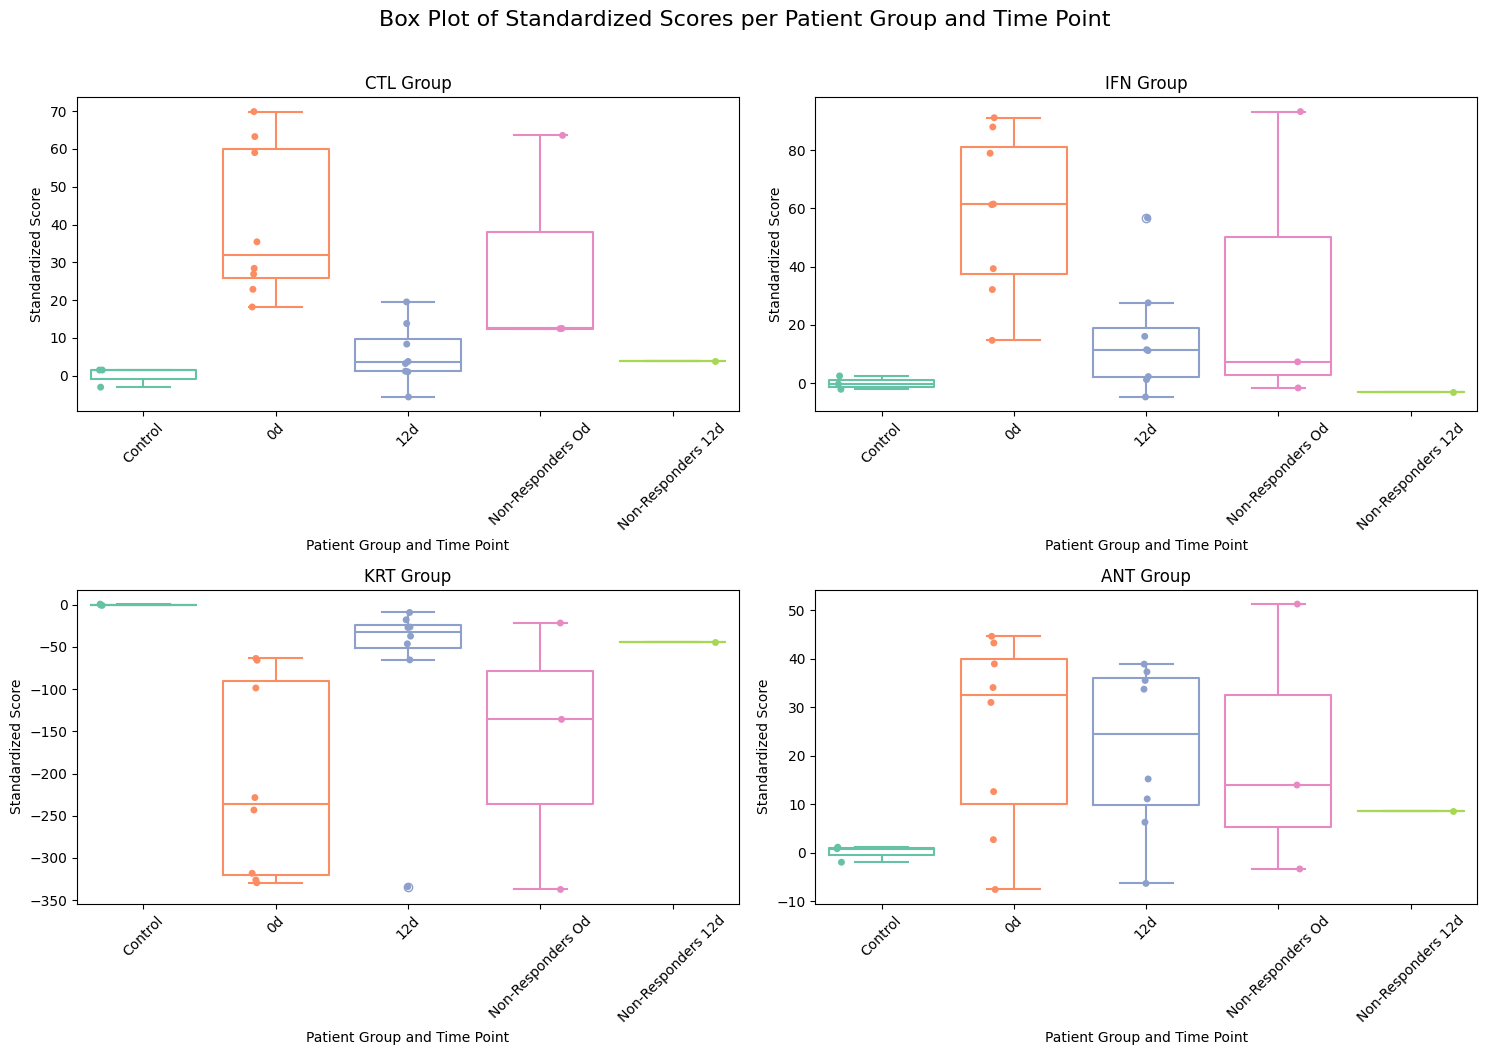

In [66]:
# Initialize the matplotlib figure with a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten() # Flatten the axes array for easy iteration

data_frames_for_plotting = []

# Loop over each DataFrame and each group of columns to plot
for time_point, columns in groups_and_columns.items():

  # Extract the standardized scores for the current patient group
  temp_df = sum_df_sscore_all_transposed[columns].copy()
  temp_df = temp_df.stack().reset_index(name='StandardizedScore')
  temp_df.drop('level_1', axis=1, inplace=True)  # Drop the level created by stack
  temp_df['TimePoint'] = time_point

  data_frames_for_plotting.append(temp_df)

# Concatenate all reshaped data frames for final plotting
data_for_plotting = pd.concat(data_frames_for_plotting, ignore_index=True)

# Create a boxplot and strip plot for each group in separate subplots
for ax, group_name in zip(axes, group_names):
    subset = data_for_plotting[data_for_plotting['level_0'] == group_name]
    sns.boxplot(x='TimePoint', y='StandardizedScore', hue='TimePoint', data=subset, ax = ax, palette='Set2',fill=False)
    sns.stripplot(x='TimePoint', y='StandardizedScore', hue='TimePoint', data=subset,
                  ax=ax, palette='Set2', dodge=True, jitter=True, alpha=1, color='black')
    ax.set_title(f'{group_name} Group')
    ax.set_xlabel('Patient Group and Time Point')
    ax.set_ylabel('Standardized Score')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and add a main title
plt.tight_layout()
plt.suptitle('Box Plot of Standardized Scores per Patient Group and Time Point', fontsize=16, y=1.05)
plt.savefig(f'/content/google_drive/MyDrive/440 project E + V 4ever/Results/Figures/Gene_Expression_Boxplots_Standarized-score.png', bbox_inches='tight')
plt.show()

##13. Student T-Test in ALADIN

In [68]:
# Identify all unique timepoints in your DataFrame
timepoints = data_for_plotting['TimePoint'].unique()

# Create all unique pairings of timepoints
timepoint_combinations = itertools.combinations(timepoints, 2)

# Initialize an empty DataFrame to store t-test results
t_test_results = pd.DataFrame(columns=['Group', 'Timepoint1', 'Timepoint2', 'T-Statistic', 'P-Value'])

# Iterate over each combination of timepoints and perform t-tests
for timepoint1, timepoint2 in timepoint_combinations:
    print(f"Comparing {timepoint1} vs {timepoint2}:")

    for group in group_names:
        # Filter the standardized scores for the two timepoints within the current group
        scores_timepoint1 = data_for_plotting[(data_for_plotting['TimePoint'] == timepoint1) & (data_for_plotting['level_0'] == group)]['StandardizedScore']
        scores_timepoint2 = data_for_plotting[(data_for_plotting['TimePoint'] == timepoint2) & (data_for_plotting['level_0'] == group)]['StandardizedScore']

        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(scores_timepoint1, scores_timepoint2, equal_var = False)

        # Create a new row with the results
        result_row = pd.DataFrame({
            'Group': [group],
            'Timepoint1': [timepoint1],
            'Timepoint2': [timepoint2],
            'T-Statistic': [t_stat],
            'P-Value': [p_value]
        })

        # Append the results to the t_test_results DataFrame
        t_test_results = pd.concat([t_test_results, result_row], ignore_index=True)

        # Output the results
        print(f"{group} P-value: {p_value}")

# Save the t_test_results DataFrame to CSV
t_test_results.to_csv('/content/google_drive/MyDrive/440 project E + V 4ever/Results/Dataframes/Statistical_tests_results.csv', index=False)


Comparing Control vs 0d:
CTL P-value: 0.000678398661198684
IFN P-value: 0.0005161570240176357
KRT P-value: 0.0014587076601996702
ANT P-value: 0.009034055414780829
Comparing Control vs 12d:
CTL P-value: 0.10967614973083702
IFN P-value: 0.06494803930555089
KRT P-value: 0.10791940341032145
ANT P-value: 0.009235637493172343
Comparing Control vs Non-Responders Od:
CTL P-value: 0.2245869087202257
IFN P-value: 0.3897570868321803
KRT P-value: 0.21600010193122485
ANT P-value: 0.3289109183101431
Comparing Control vs Non-Responders 12d:
CTL P-value: nan
IFN P-value: nan
KRT P-value: nan
ANT P-value: nan
Comparing 0d vs 12d:
CTL P-value: 0.0014203455068036433
IFN P-value: 0.003359240223136509
KRT P-value: 0.027214136680272564
ANT P-value: 0.7124258331757563
Comparing 0d vs Non-Responders Od:
CTL P-value: 0.5978659883775398
IFN P-value: 0.49480133589504366
KRT P-value: 0.6928375830841775
ANT P-value: 0.8226567805453331
Comparing 0d vs Non-Responders 12d:
CTL P-value: nan
IFN P-value: nan
KRT P-valu

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
